Con questo Jupyter Notebook voglio mostrare come ho elaborato i dati CAMS relativi al PM10 di cui ho parlato in [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/). I dati grezzi sono in formato NetCDF e di come gestire questo particolare formato dati ne ho parlato in un [altro articolo](https://massimilianomoraca.me/blog/pygis-blog/gestione-di-un-file-netcdf/) che, nemmeno a farlo apposta, è incentrato sui dati CAMS.

# Prima di iniziare

## Librerie

Le librerie Python usate per raggiungere lo scopo sono state diverse e le vedrete di seguito. Una però deve essere menzionata tra tutte [Dask](https://www.dask.org/); senza l'uso di questa librerie non mi sarebbe stato possibile velocizzare i processamenti che, nonostante tutto, sono durati ore.

In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from geocube.api.core import make_geocube
from xrspatial.zonal import stats
import pandas as pd
import dask.dataframe as dd

from pandas import DataFrame
from xarray import Dataset, DataArray
from geopandas import GeoDataFrame
from typing import Union

## Fonti dati

I dati del PM10 dal 2013 allo scorso marzo sono il perno di questa analisi a cui ho associato i dati vettoriali dell'ISTAT delle province target(quelle che ricadono nelle regioni con codice da 1 a 11) e sulla popolazione per cella censuaria. Dopo aver scaricato i dati CAMS li ho preprocessati in modo da avere un file `.nc` per anno.

In [2]:
nc_data_path = Path("/home/max/Desktop/pianura_padana/processed/netcdf")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2021-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2014-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2015-reanalyses.nc'),
 PosixPath('/home/max/Desktop/

In [3]:
target_zones_boundaries = Path("/home/max/Desktop/DEV/DrakoNotebook/open_dataset/Limiti01012023_g/ProvCM01012023_g/ProvCM01012023_g_WGS84.shp")

target_zones = gpd.read_file(target_zones_boundaries)
target_zones = target_zones[target_zones['COD_REG'].isin(list(range(1, 12)))]
target_zones = target_zones.to_crs(4326).sort_values('DEN_UTS')

target_zones

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Area,geometry
20,2,4,21,0,21,Bolzano,-,Bolzano,BZ,Provincia autonoma,7.399378e+09,"POLYGON ((12.20511 47.08653, 12.20668 47.08627..."


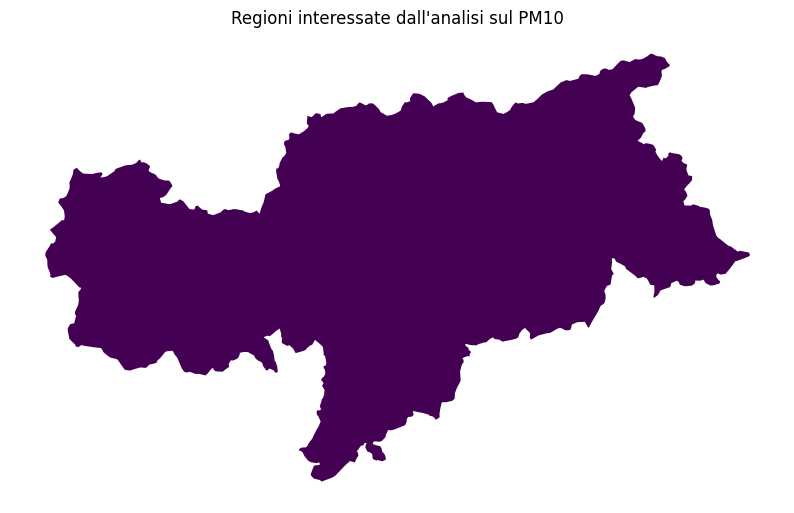

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

target_zones.plot(
    ax=ax,
    column='COD_REG',
)
plt.title("Regioni interessate dall'analisi sul PM10")
plt.axis('off')
plt.show()

## Contenuti
- [Aggregazione dei dati](#Aggregazione-dei-dati)
- 
- [Conclusione](#Conclusione)

# Aggregazione dei dati

Lo scopo di questa attività è stato quello di aggregare i dati su base provinciale e di generare un `.csv` per Provincia. I tempi di calcolo sono davvero lunghi, notate la funzione `%%time` cosa stampa. 

In [5]:
csv_folder = Path("/home/max/Desktop/pianura_padana/processed/target_zones")

In [6]:
%%time

# Analisi per Provincia
for _index, _row in target_zones.iterrows():
    zone_gdf = target_zones[target_zones['COD_PROV'] == _row['COD_PROV']]
    
    zone_data = []
    
    # Lettura dei singoli `.nc`
    for file in nc_files:
        year_data = xr.open_dataset(
            filename_or_obj=file,
            engine="netcdf4",
            decode_coords="all",
        )
        
        # Riordinamento delle coordinate per evitare problemi di dimensione
        year_data = year_data.transpose('lat', 'lon', 'time')[['lat', 'lon', 'time', 'particulate_matter_10um']]
        
        time_coords = year_data['time'].values
        
        # Calcolo delle zonal statistic
        for time in time_coords:
            sensing_date = time.astype('datetime64[s]').item()

            time_data = year_data.sel(time=time).to_dataarray().squeeze()
            
            # Definizione delle dimensioni spaziali
            time_data = time_data.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
            
            # Rasterizzazione del poligono della Provincia
            rasterized_vector = make_geocube(
                vector_data=zone_gdf,
                measurements=['COD_PROV'],
                like=time_data,
            )
            vector_dataarray = rasterized_vector['COD_PROV']
            
            zonal_statistics = stats(
                zones=vector_dataarray,
                values=time_data,
                stats_funcs=["mean", "max", "min", "sum", "std", "count", "var"]
            )
            zonal_statistics.rename(columns={"zone": 'COD_PROV'}, inplace=True)

            zs_merged = pd.merge(
                left=zonal_statistics,
                right=zone_gdf,
                how='left',
                on='COD_PROV'
            )
            zs_merged = zs_merged[['COD_PROV', 'DEN_UTS', 'mean', 'max', 'min', 'sum', 'std', 'count', 'var']]
            zs_merged['sensing_date'] = sensing_date

            zone_data.append(zs_merged)
            #break
        
        
        #break
    # Aggregazione e generazione del csv
    zone_ddf = dd.concat(zone_data)
    zone_df = zone_ddf.compute()

    zone_df.to_csv(csv_folder.joinpath(f"zs_{_row['COD_PROV']}_{_row['DEN_UTS']}.csv"))
    
    
    #break

['2021-01-01T00:00:00.000000000' '2021-01-01T01:00:00.000000000'
 '2021-01-01T02:00:00.000000000' '2021-01-01T03:00:00.000000000'
 '2021-01-01T04:00:00.000000000' '2021-01-01T05:00:00.000000000'
 '2021-01-01T06:00:00.000000000' '2021-01-01T07:00:00.000000000'
 '2021-01-01T08:00:00.000000000' '2021-01-01T09:00:00.000000000']
['2017-01-01T00:00:00.000000000' '2017-01-01T01:00:00.000000000'
 '2017-01-01T02:00:00.000000000' '2017-01-01T03:00:00.000000000'
 '2017-01-01T04:00:00.000000000' '2017-01-01T05:00:00.000000000'
 '2017-01-01T06:00:00.000000000' '2017-01-01T07:00:00.000000000'
 '2017-01-01T08:00:00.000000000' '2017-01-01T09:00:00.000000000']
['2020-01-01T00:00:00.000000000' '2020-01-01T01:00:00.000000000'
 '2020-01-01T02:00:00.000000000' '2020-01-01T03:00:00.000000000'
 '2020-01-01T04:00:00.000000000' '2020-01-01T05:00:00.000000000'
 '2020-01-01T06:00:00.000000000' '2020-01-01T07:00:00.000000000'
 '2020-01-01T08:00:00.000000000' '2020-01-01T09:00:00.000000000']
['2014-01-01T00:00:00.

La configurazione dell'hardware che ho usato per questa analisi è quella di un **Dell XPS15 9530 con CPU i7-13700H, RAM 64GB DDR5, GPU NVIDIA GeForce RTX4050 con 6GB GDDR6**.